# Imports

In [144]:
# Python standard library
import sys

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [145]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [146]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

# Load template and create stage

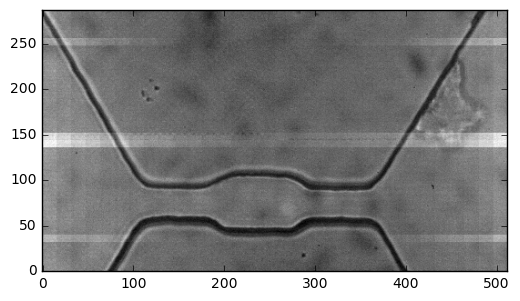

In [147]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

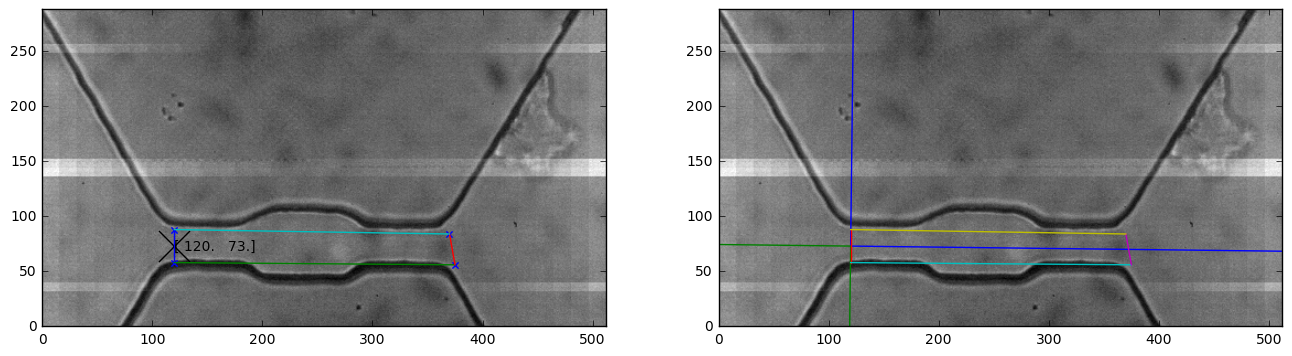

In [148]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [120,88]
c1 = [120,58]
c2 = [375,56]
c3 = [370,84]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Filter out bad events

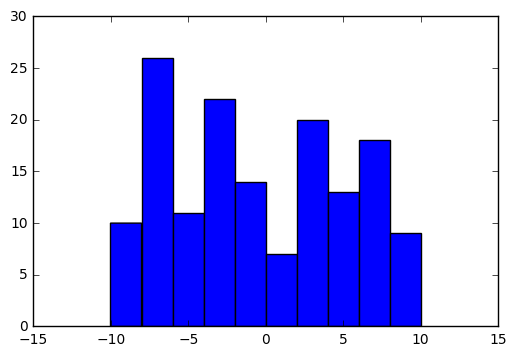

In [149]:
# Central cavity y-based filtering

yc_middles = []

for oi_event in oi_events:
    
    # Calculate y at center of channel
    xs = oi_event.get_px()
    ys = oi_event.get_py()
    tfs = oi_event.get_tf()
    tfs = np.array(tfs)
    tfs = tfs - tfs[0]
    
    xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
    xcs = oi_stage.pixels_to_meters(xcs)
    ycs = oi_stage.pixels_to_meters(ycs)
    
    tfs_interp = scipy.interpolate.interp1d(xcs, tfs)
    
    tf_middle = int(tfs_interp(oi_stage._length_microns/2.))
    
    
    yc_middles.append(ycs[tf_middle])
    
    
    
    
# Apply offset to y so centered at 0
offset = -(np.max(yc_middles) - np.abs(np.min(yc_middles)))/2.
yc_middles = np.array(yc_middles)
yc_middles = yc_middles + offset


# Plot hist of all ys
plt.hist(yc_middles)
plt.show()

In [150]:
# Filter y
max_yc = 5
keep_indices = np.where(np.abs(yc_middles) <= max_yc)[0]
oi_events = [oi_events[i] for i in keep_indices]

# Find a good event

In [155]:
oi_index = 16
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

# Plotting functions

In [156]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()
    
    

# Negative thresholding

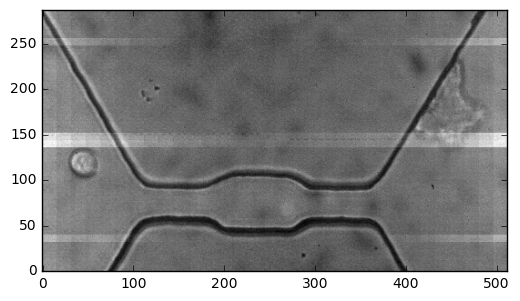

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


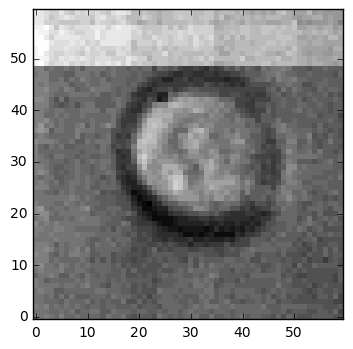

In [159]:
oi_event = oi_events[oi_index]
detection = oi_event._detections[35]
raw_frame = oi_vid.get_frame(detection._tf)

plt.imshow(raw_frame, cmap = 'gray', origin = 'lower')
plt.show()

x0 = detection._px- 30
x1 = detection._px + 30
y0 = detection._py - 30
y1 = detection._py + 30
plt.imshow(raw_frame[y0:y1, x0:x1], cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.show()

absolute value difference
copy


/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


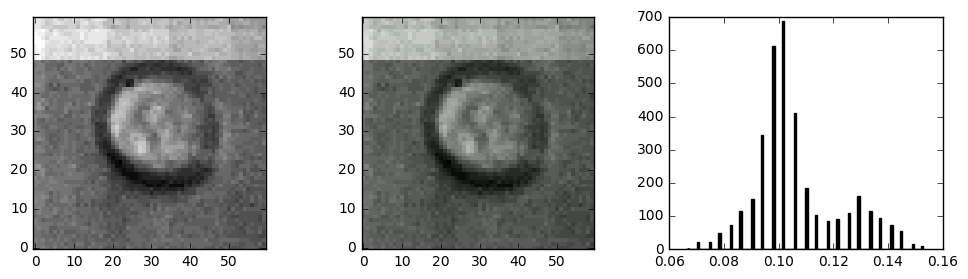

negative


/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


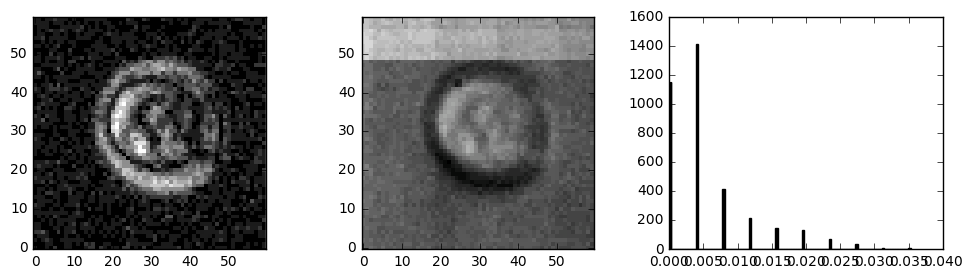

gaussian blur


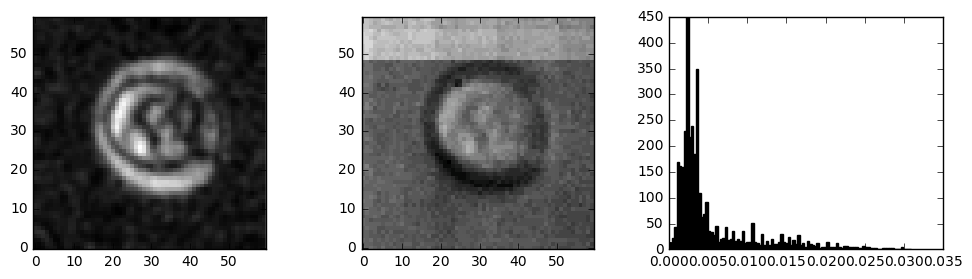

rescale


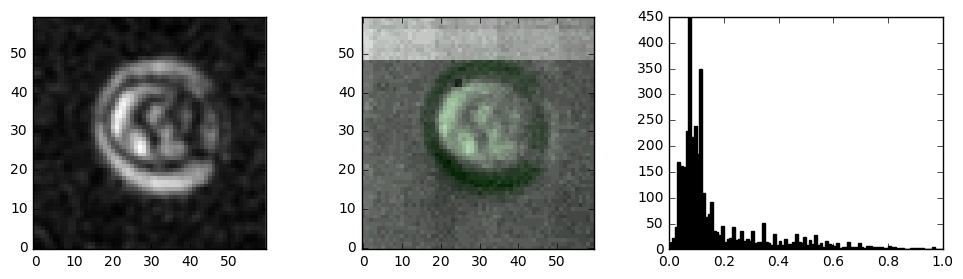

threshold


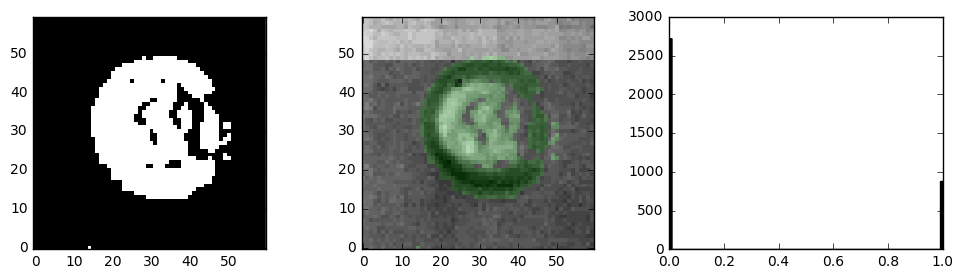

erode subtraction


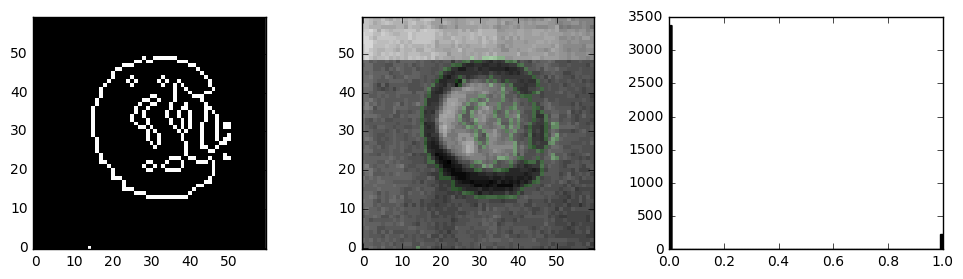

fill holes


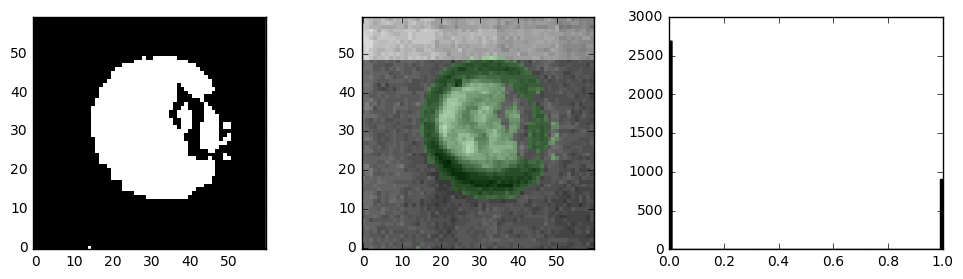

clustering


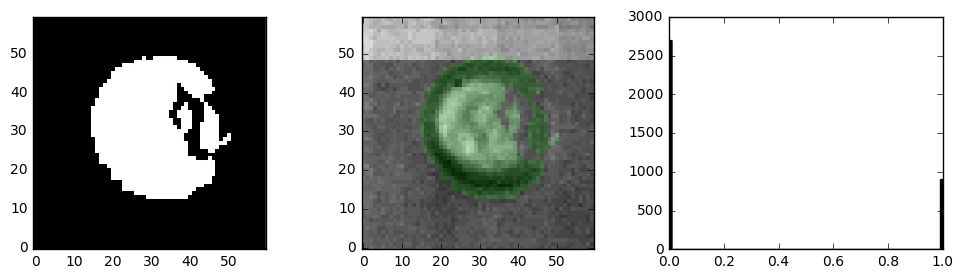

morphological closing


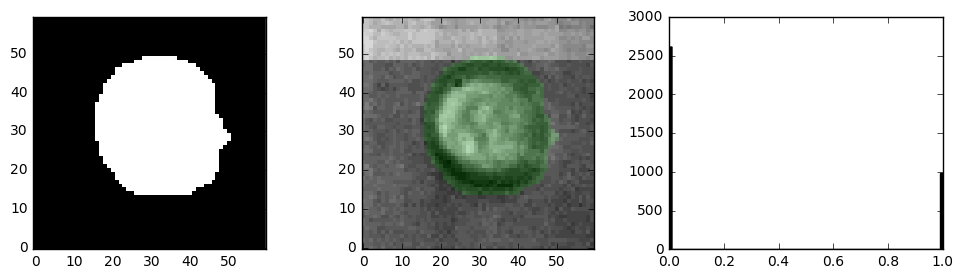

erode subtraction


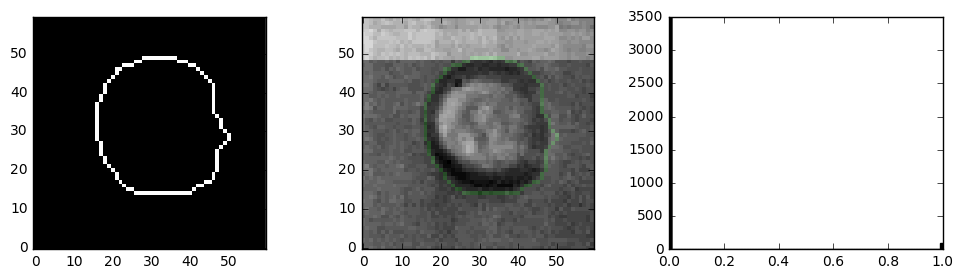

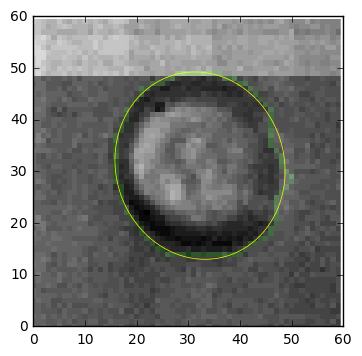

In [160]:
print 'absolute value difference'



# Crop raw frame
x0 = detection._px - 30
x1 = detection._px + 30
y0 = detection._py - 30
y1 = detection._py + 30
frame = raw_frame[y0:y1, x0:x1]

# Copy
print 'copy'
processed_frame = 1.*frame
plot_all(processed_frame, frame)

# Negative
print 'negative'
processed_frame = np.abs(frame - template_frame[y0:y1, x0:x1])
plot_all(processed_frame, frame)

# Blur
print 'gaussian blur'
window = (3,3)
processed_frame = cv2.GaussianBlur(processed_frame, window, 0)
plot_all(processed_frame, frame)

# Rescale
print 'rescale'
processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))
plot_all(processed_frame, frame)

# Threshold
print 'threshold'
threshold = .2
processed_frame[processed_frame > threshold] = 1
processed_frame[processed_frame <= threshold] = 0
plot_all(processed_frame, frame)





# Erode subtraction
print 'erode subtraction'
processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)
plot_all(processed_frame, frame)


# Fill holes
print 'fill holes'
processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)
plot_all(processed_frame, frame)

# Get largest cluster
print 'clustering'
clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
for pixel in largest_cluster:
    processed_frame[pixel[0], pixel[1]] = 1
plot_all(processed_frame, frame)



# Morphological closing
print 'morphological closing'
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)
plot_all(processed_frame, frame)



# Dilate/erode subtraction
print 'erode subtraction'
processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)
plot_all(processed_frame, frame)




# Fit ellipse
cell_pixels = np.where(processed_frame == 1)

ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
ellipse_center = oi.get_ellipse_center(ellipse)
ellipse_angle = oi.get_ellipse_angle_of_rotation(ellipse)
ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)



ellipse_points = np.empty((100,2))
for i in range(100):
    angle = i*2*np.pi/99.
    x = ellipse_axes[0]*np.cos(angle)
    y = ellipse_axes[1]*np.sin(angle)
    ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
    ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
green_processed_frame[:,:,1] = processed_frame



plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

plt.xlim(0, frame.shape[1])
plt.ylim(0, frame.shape[0])

plt.show()
    

# Preprocess and fit ellipse to all detections

In [161]:
def preprocess_frame(raw_frame, template_frame, plot = False):
    


    # Crop raw frame
    x0 = detection._px - 30
    x1 = detection._px + 30
    y0 = detection._py - 30
    y1 = detection._py + 30
    frame = raw_frame[y0:y1, x0:x1]

    # Copy
    processed_frame = 1.*frame

    # Negative
    processed_frame = np.abs(frame - template_frame[y0:y1, x0:x1])

    # Blur
    window = (3,3)
    processed_frame = cv2.GaussianBlur(processed_frame, window, 0)

    # Rescale
    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))

    # Threshold
    threshold = .15
    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0





    # Erode subtraction
    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)


    # Fill holes
    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)

    # Get largest cluster
    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1



    # Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)



    # Dilate/erode subtraction
    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)
    
    
    
    # Fit ellipse
    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_angle = oi.get_ellipse_angle_of_rotation(ellipse)
    ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)
    


    if plot:
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes[0]*np.cos(angle)
            y = ellipse_axes[1]*np.sin(angle)
            ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
            ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame



        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

        plt.xlim(0, frame.shape[1])
        plt.ylim(0, frame.shape[0])

        plt.show()
    
    
    
    
    return ellipse

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


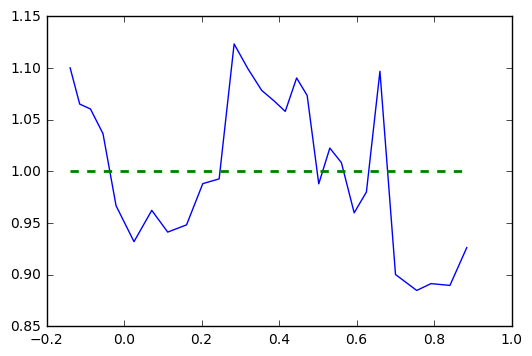

In [162]:
oi_event = oi_filtered_events[7]

oi_event.get_channel_enter_exit_tf(oi_stage)


xcs = []
aspects = []


for i in range(oi_event._channel_enter_tf-5, oi_event._channel_exit_tf-1):
    detection = oi_event._detections[i - oi_event._detections[0]._tf]
    raw_frame = oi_vid.get_frame(detection._tf)
    
    ellipse = preprocess_frame(raw_frame, template_frame, plot = False)
    
    ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)
    
    x = detection._px
    y = detection._py
    
    xc, yc = oi_stage.get_channel_coordinates(x, y)
    xc = oi_stage.pixels_to_meters(xc)
    xcs.append(xc/oi_stage._length_microns)
    aspects.append(ellipse_axes[0]/ellipse_axes[1])
    
plt.plot(xcs, aspects)
plt.plot([np.array(xcs).min(),np.array(xcs).max()], [1,1], lw = 2, ls = '--')
plt.show()

### Find maximum and minimum aspect ratios

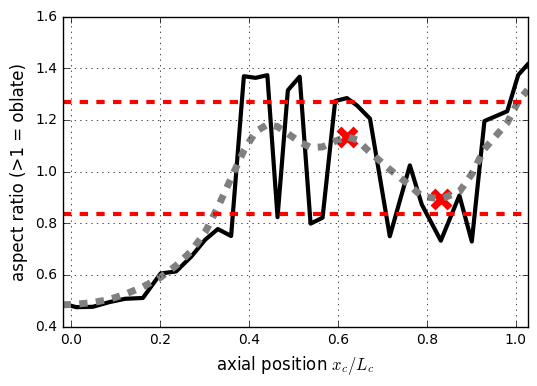

In [177]:
# Smooth the aspect ratio signal
sigma = 2
aspects_smoothed = scipy.ndimage.filters.gaussian_filter(aspects, sigma = sigma)

# Find minima and maxima in the aspect ratios
maxima, minima = rp.get_maxima_minima(aspects, num_maxima = 1, num_minima = 1, sigma = sigma, return_by = 'low')

maxima = maxima[0]
minima = minima[0]


# Average in a window around the local minima and maxima
window_size = 3
max_aspect = np.mean(aspects[maxima-window_size/2:maxima+window_size/2+1])
min_aspect = np.mean(aspects[minima-window_size/2:minima+window_size/2+1])






# Create plot

# Plot aspects, smoothed aspects
plt.plot(xcs, aspects, lw = 3, c = 'k')
plt.plot(xcs, aspects_smoothed, c = 'gray', ls = '--', lw = 5)


# Plot the minima/maxima as detected in the smoothed signal
plt.scatter(xcs[maxima], aspects_smoothed[maxima], s = 150, marker = 'x', lw = 5, color = 'red')
plt.scatter(xcs[minima], aspects_smoothed[minima], s = 150, marker = 'x', lw = 5, color = 'red')

# Plot the averaged minima/maxima
plt.plot([xcs[0], xcs[-1]], [max_aspect, max_aspect], ls = '--', lw = 3, c = 'red')
plt.plot([xcs[0], xcs[-1]], [min_aspect, min_aspect], ls = '--', lw = 3, c = 'red')


plt.xlim(np.min(xcs), np.max(xcs))

# Cosmetics
plt.xlabel(r'axial position $x_{c}/L_{c}$', size = 12)
plt.ylabel(r'aspect ratio (>1 = oblate)', size = 12)
plt.grid()






plt.show()

### Calculate minimum and maximum aspect for all events

In [166]:
def find_max_min_aspects(aspects):
    # Smooth the aspect ratio signal
    sigma = 2
    aspects_smoothed = scipy.ndimage.filters.gaussian_filter(aspects, sigma = sigma)

    # Find minima and maxima in the aspect ratios
    maxima, minima = rp.get_maxima_minima(aspects, num_maxima = 1, num_minima = 1, sigma = sigma, return_by = 'low')

    maxima = maxima[0]
    minima = minima[0]


    # Average in a window around the local minima and maxima
    window_size = 3
    max_aspect = np.mean(aspects[maxima-window_size/2:maxima+window_size/2+1])
    min_aspect = np.mean(aspects[minima-window_size/2:minima+window_size/2+1])


    return max_aspect, min_aspect

In [168]:
max_aspects = []
min_aspects = []

for i, oi_event in enumerate(oi_events):

    
    try:
        oi_event.get_channel_enter_exit_tf(oi_stage)


        xcs = []
        aspects = []


        for i in range(oi_event._channel_enter_tf-5, oi_event._channel_exit_tf-1):
            detection = oi_event._detections[i - oi_event._detections[0]._tf]
            raw_frame = oi_vid.get_frame(detection._tf)

            ellipse = preprocess_frame(raw_frame, template_frame, plot = False)

            ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)

            x = detection._px
            y = detection._py

            xc, yc = oi_stage.get_channel_coordinates(x, y)
            xc = oi_stage.pixels_to_meters(xc)
            xcs.append(xc/oi_stage._length_microns)
            aspects.append(ellipse_axes[0]/ellipse_axes[1])

        max_aspect, min_aspect = find_max_min_aspects(aspects)

        max_aspects.append(max_aspect)
        min_aspects.append(min_aspect)
        
    except: 
        print 'failed on event', i

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


failed on event 44


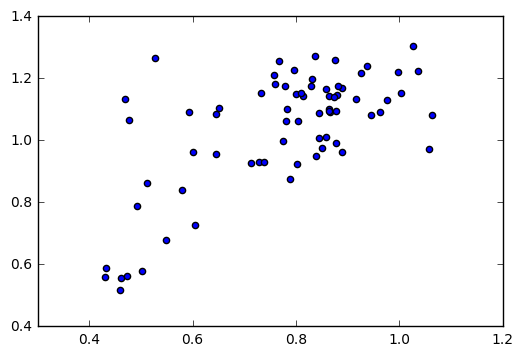

In [173]:
plt.scatter(min_aspects, max_aspects)

plt.show()

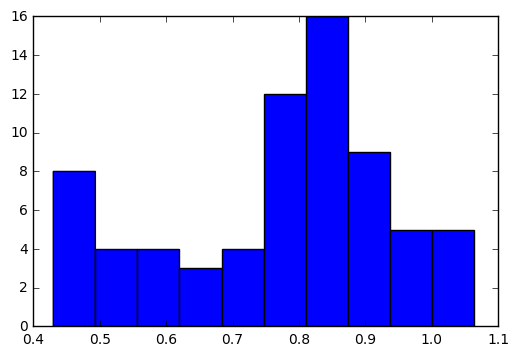

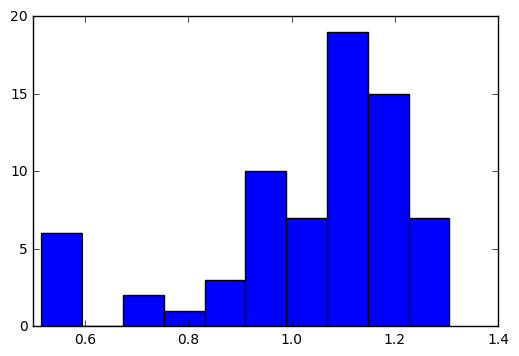

In [174]:
plt.hist(min_aspects)
plt.show()

plt.hist(max_aspects)
plt.show()